## Algodoo用台車型倒立振子制御器設計
Algodooでの台車型倒立振子のための安定化制御器を簡易的に設計する．制御対象モデル導出は省略するが，駆動力を制御入力とし，平衡点近傍で線形近似したものを使用する．

解説元 : Algodooによる台車型倒立振子の安定化制御 [https://kawazu-gkgk.hatenablog.jp/entry/2020/06/28/000855](https://kawazu-gkgk.hatenablog.jp/entry/2020/06/28/000855)  
動画 : Algodooで倒立振子制御 [https://youtu.be/t2z4UIa5c-U](https://youtu.be/t2z4UIa5c-U)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as ml

In [2]:
# character of inverted pendulum cart
g = 9.8 # acceleration of gravity [m/s^2]

mp = 2.0 * 0.25 * 3.0 # mass of pendulum [kg]
Jp = 2.0 * 0.25 * 3.0**3 / 12 # inertia of pendulum [kgm^2]
l = 3.0 /2 - 0.125 # COG hight of pendulum [m]

mc = 2.0 * 3.5 * 0.75 + 1.5 * 3.14 * 0.5**2 * 2 # mass of cart w tire [kg]

In [3]:
# matrix element
a23 = mp**2 * l**2 * g / ((mc + mp)*(Jp + l**2) - mp**2 * l**2)
a43 = mp * (mc + mp) * l * g / ((mc + mp)*(Jp + l**2) - mp**2 * l**2)
b2 = (Jp + l**2) / ((mc + mp)*(Jp + l**2) - mp**2 * l**2)
b4 = mp * l / ((mc + mp)*(Jp + l**2) - mp**2 * l**2)

# system matrix of plant
# state vector x = t[x1, x2, x3, x4]
# x1 : cart displacement [m]
# x2 : cart velocity [m/s]
# x3 : pendulum angle [rad]
# x4 : pendulum anglar velocity [rad/s]
A = np.array([[0, 1, 0, 0],[0, 0, a23, 0],[0, 0, 0, 1],[0, 0, a43, 0]])
B = np.array([[0],[b2],[0],[b4]])
C = np.array([1, 0, 0, 0])
D = 0

In [4]:
# eigen structure
eig_val, eig_vec = np.linalg.eig(A)
print(eig_val)
print(eig_vec)

[ 0.          0.          2.81627175 -2.81627175]
[[ 1.00000000e+000 -1.00000000e+000  7.39245232e-002 -7.39245232e-002]
 [ 0.00000000e+000  4.00833672e-292  2.08191546e-001  2.08191546e-001]
 [ 0.00000000e+000  0.00000000e+000  3.26343168e-001 -3.26343168e-001]
 [ 0.00000000e+000  0.00000000e+000  9.19071043e-001  9.19071043e-001]]


In [5]:
# open-loop state-space system
sys = ml.ss(A, B, C, D)
print(sys)

A = [[0.         1.         0.         0.        ]
 [0.         0.         1.79664852 0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         7.93138655 0.        ]]

B = [[0.        ]
 [0.12996502]
 [0.        ]
 [0.08888799]]

C = [[1. 0. 0. 0.]]

D = [[0.]]



(array([ 0.        ,  0.        ,  2.81627175, -2.81627175]),
 array([-2.58893621+0.j,  2.58893621+0.j]))

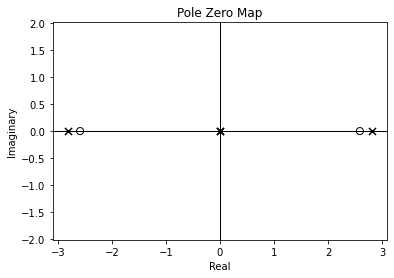

In [6]:
# open-loop pz map
ml.pzmap(sys)

### 極配置
簡単な設計で済ませたいため，ここでは極配置設計に代表二次極法を用いる．  
駆動力入力から台車位置出力への零点は±2.6にある．閉ループ極をこの零点位置より原点から離れた位置に配置した場合，システムの応答に零点の影響(オーバーシュートに加えてこのシステムでは不安定零点があるため逆振れが発生する)が大きくなる．  
この台車型倒立振子ではタイヤトルクが大きすぎたり急に立ち上がるような場合にスリップが発生するため，応答は速過ぎずオーバーシュートもなるべく小さくすることでスリップによる不安定化を抑えたい．  
したがって極配置は代表二次極を零点より原点に近い半径1のバターワースパターン配置，残り2つの極は代表2次極の3倍の距離に実極でとる．

In [7]:
# closed-loop pole assignment
pole_cl = np.array([-3.0, -3.01, 1 * complex(-1.0/np.sqrt(2), 1.0/np.sqrt(2)), 1 * complex(-1.0/np.sqrt(2), -1.0/np.sqrt(2))])

fb_gain = ml.place(A, B, pole_cl)
fb_gain

matrix([[-10.36617614, -21.55929127, 312.84372612, 115.04554331]])

注 : 関数`matlab.place`によるフィードバックゲイン計算では重極配置ができないため，2つの実極は少々ずらして配置している．

(array([-3.01      +0.j        , -3.        +0.j        ,
        -0.70710678+0.70710678j, -0.70710678-0.70710678j]),
 array([ 2.58893621+0.j, -2.58893621+0.j]))

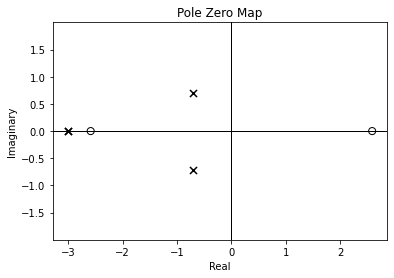

In [8]:
#closed-loop pz map
sys_cl = ml.ss(A-B*fb_gain, B, C, D)
ml.pzmap(sys_cl)

In [9]:
# convert feedback gain to motor torque
fb_gain_tq = fb_gain * 0.5 # Tq = F * <tire radius>
fb_gain_tq

matrix([[ -5.18308807, -10.77964563, 156.42186306,  57.52277166]])

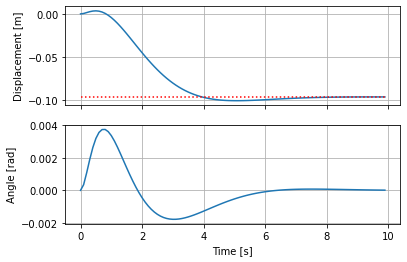

In [10]:
# step response
ystep_dist, t_dist = ml.step(sys_cl)
stepsig = np.full(len(t_dist),ml.dcgain(sys_cl))
ystep_ang, t_ang = ml.step(ml.ss(A-B*fb_gain, B, [0, 0, 1, 0], D))

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t_dist, ystep_dist)
ax[0].plot(t_dist, stepsig, color='r', linestyle='dotted')
ax[0].set_ylabel("Displacement [m]")
ax[0].grid()
ax[1].plot(t_ang, ystep_ang)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Angle [rad]")
ax[1].grid()